In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


**Import Packages:**

In [2]:
#for dataframes
import numpy as np
import pandas as pd

#for model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical 

#for cross validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

#for creating iterators for efficient looping
import itertools

#for visualization
import matplotlib.pyplot  as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

sns.set(style = "white")

Using TensorFlow backend.


**Load Data:**

In [3]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_final = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

**Check data:**

In [4]:
#checking size
print(data.columns)
print()
print(data.shape)
print()

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

(42000, 785)



1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


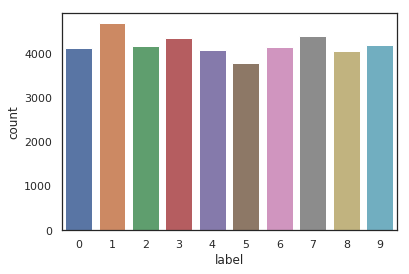

In [5]:
#checking numbers
print(data['label'].value_counts())
sns.countplot(data = data, x = 'label')

In [6]:
dataX = data.drop(['label'], axis = 1)
dataY = data['label']
dataX.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [7]:
data_clean = [dataX, test_final]
#checking for missing data
for df in data_clean:
    print(df.isnull().any().describe())
    print()
print(dataY.isnull().sum())

count       784
unique        1
top       False
freq        784
dtype: object

count       784
unique        1
top       False
freq        784
dtype: object

0


Interpretation: No missing data found

**Process the data:**

In [8]:
#Normalization
dataX = dataX/255.0
test_final = test_final/255.0

In [9]:
#Reshape
dataX = dataX.values.reshape(-1, 28, 28, 1)
test_final = test_final.values.reshape(-1, 28, 28, 1)

In [10]:
#label encode
dataY = to_categorical(dataY, num_classes = 10)
dataY

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
#split train, test
x_train , x_test, y_train, y_test = train_test_split(dataX, dataY, test_size = 0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(37800, 28, 28, 1)
(4200, 28, 28, 1)
(37800, 10)
(4200, 10)


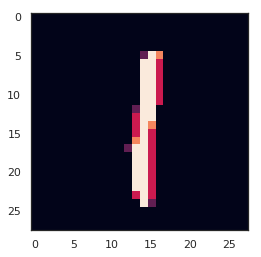

In [12]:
plt.imshow(x_train[1][:,:,0])

**Create a model:**

In [13]:
#sequential model is a linear stack of layer
model = Sequential()

#computes 2D convolution of a given 4D input
'''1st convolution+maxpool layer with
32 filters, 5X5 feature detectors with rectifier fuction to increase non linearity'''
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

'''2nd convolution+maxpool layer with
64 filters, 3X3 feature detectors with rectifier fuction to increase non linearity'''
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

#converts convolutional part of CNN into a 1D feature vector of ANN
model.add(Flatten())

#fully connected layer
model.add(Dense(256, activation = 'relu')) 
model.add(Dropout(0.50))
model.add(Dense(10, activation = 'softmax'))

#optimizing
optimizer = RMSprop(lr = 0.001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Reduce learning rate when a metric has stopped improving:**

In [14]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', #accuracy monitored
                              verbose = 1, # update messages.
                              patience = 5, #after 5 epochs
                              factor = 0.5 ,#learning rate will be half
                              min_lr = 0.00001 #minimum learning rate
                             ) 

**Data augmentation:**

In [15]:
#data augmentation
'''
creates batches of images by shifting, zooming, rotating 
prevents overfitting
'''
augment_data = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images by 10 degree
        zoom_range = 0.1, # Randomly zoom image by 10%
        width_shift_range=0.1,  # randomly shift images horizontally by 10%
        height_shift_range=0.1,  # randomly shift images vertically by 10%
        horizontal_flip=False,  # no random horizontal flipping allowed
        vertical_flip=False) # no random vertical flipping allowed

augment_data.fit(x_train)

**Fit the model:**

In [16]:
epochs = 40
batch_size = 64
train_set = augment_data.flow(x_train, y_train, batch_size =  batch_size)
test_set = (x_test, y_test)

In [17]:
details = model.fit_generator(
    train_set,
    validation_data = test_set,
    epochs = epochs,
    verbose = 2,
    steps_per_epoch = x_train.shape[0]//batch_size,
    callbacks = [reduce_lr]
)

Epoch 1/40
 - 13s - loss: 0.5930 - accuracy: 0.8058 - val_loss: 0.0675 - val_accuracy: 0.9798
Epoch 2/40
 - 11s - loss: 0.1881 - accuracy: 0.9449 - val_loss: 0.0473 - val_accuracy: 0.9862
Epoch 3/40
 - 11s - loss: 0.1360 - accuracy: 0.9597 - val_loss: 0.0464 - val_accuracy: 0.9857
Epoch 4/40
 - 11s - loss: 0.1110 - accuracy: 0.9679 - val_loss: 0.0593 - val_accuracy: 0.9833
Epoch 5/40
 - 11s - loss: 0.1014 - accuracy: 0.9712 - val_loss: 0.0343 - val_accuracy: 0.9905
Epoch 6/40
 - 11s - loss: 0.0971 - accuracy: 0.9727 - val_loss: 0.0337 - val_accuracy: 0.9890
Epoch 7/40
 - 11s - loss: 0.0894 - accuracy: 0.9754 - val_loss: 0.0341 - val_accuracy: 0.9900
Epoch 8/40
 - 12s - loss: 0.0896 - accuracy: 0.9751 - val_loss: 0.0491 - val_accuracy: 0.9890
Epoch 9/40
 - 11s - loss: 0.0869 - accuracy: 0.9765 - val_loss: 0.0412 - val_accuracy: 0.9888
Epoch 10/40
 - 11s - loss: 0.0900 - accuracy: 0.9760 - val_loss: 0.0318 - val_accuracy: 0.9924
Epoch 11/40
 - 11s - loss: 0.0956 - accuracy: 0.9757 - val_

**Model evaluation:**

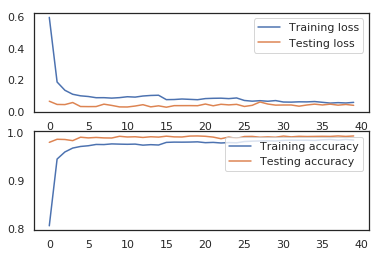

In [18]:
#plotting train, test accuracy
fig, ax = plt.subplots(2, 1)
ax[0].plot(details.history['loss'], label = 'Training loss')
ax[0].plot(details.history['val_loss'], label = 'Testing loss')
ax[0].legend(loc = 'upper right')

ax[1].plot(details.history['accuracy'], label = 'Training accuracy')
ax[1].plot(details.history['val_accuracy'], label = 'Testing accuracy')
ax[1].legend(loc = 'upper right')
plt.show()

In [19]:
#Confusion matrix
y_pred = model.predict(x_test)
#as classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets
# we need to convert encoded y values to original digits
y_true = np.argmax(y_test, axis = 1)
y_pred = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_true, y_pred)

Text(0.5, 12.5, 'predicted value')

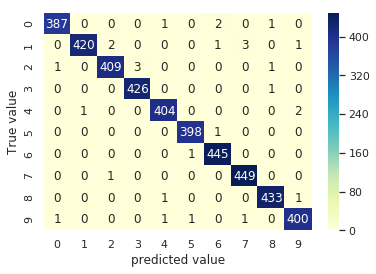

In [20]:
sns.heatmap(cm, annot = True, fmt = 'd', cmap="YlGnBu")
plt.ylabel('True value')
plt.xlabel('predicted value')

**Final submission:**

In [21]:
result = model.predict(test_final)
#convert from encoded to digit
result = np.argmax(result, axis = 1)
result = pd.Series(result,name="Label")
index = pd.Series(range(1, 28001),name="ImageID")
submission = pd.concat([index, result], axis = 1)
submission.to_csv("submission.csv", index = False)